In [1]:
import numpy as np
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram, EdgeHistogram, PyramidMatch
from grakel.kernels import SubgraphMatching, GraphletSampling, ShortestPath, RandomWalk, NeighborhoodHash
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def check_tria_ineq(K_candidate):
    D = 0.5* (np.diag(K_candidate).reshape(-1,1) @ np.ones((K_candidate.shape[0], 1)).T + np.ones((K_candidate.shape[0], 1)) @ np.diag(K_candidate).reshape(1,-1)) - K_candidate
    # sns.heatmap(D)
    # plt.title(f'Distance')
    # plt.show()
    tria_ineq = True
    for x in range(len(D)):
        if not tria_ineq: break
        for y in range(x+1, len(D)):
            if not tria_ineq: break
            for z in range(y+1, len(D)):
                if not tria_ineq: break
                diff1 = D[x,y] + D[x,z] - D[y,z]
                diff2 = D[x,z] + D[y,z] - D[x,y]
                diff3 = D[y,z] + D[x,y] - D[x,z]
                if (diff1 < 0 ) or (diff2 < 0 ) or (diff3 < 0):
                    print(f'Invalid Triangle Inequality (Triplet: No.{x+1,y+1,z+1})')
                    print(f'D[{x},{y}] + D[{x},{z}] - D[{y},{z}] {diff1}')
                    print(f'D[{x},{z}] + D[{y},{z}] - D[{x},{y}] {diff2}')
                    print(f'D[{y},{z}] + D[{x},{y}] - D[{x},{z}] {diff3}')
                    tria_ineq = False

    return tria_ineq

def check_psd(K):
    eigenValues = np.linalg.eigvals(K) #scipy.linalg.eigh(K_new, eigvals_only=True) 
    psd = 'True'
    print("K's min eigenvalue:",min(eigenValues))
    if (0 - min(eigenValues)) > 1e-08: 
        psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'
        plt.figure(figsize=(3,2))
        sns.heatmap(K)
        plt.title(f'psd: {psd}')
        plt.show()
        psd = 'True'
        K = K - float(min(eigenValues)) * np.eye(K.shape[0])
        eigenValues = np.linalg.eigvals(K) 
        print("K_new's min eigenvalue:",min(eigenValues))
        if (0 - min(eigenValues)) > 1e-08: 
            psd = f'False\nmin eig:\n{min(eigenValues)}\nneg eig num:{len(np.argwhere(eigenValues<0))}'    
    plt.figure(figsize=(3,2))
    sns.heatmap(K)
    plt.title(f'psd: {psd}')
    plt.show()

In [9]:
dataname = 'DHFR_MD'

print(f'Fetching {dataname} dataset...')
data = fetch_dataset(dataname.upper(), verbose=False, prefer_attr_nodes=False)
print(f'Finish fetching!')
G, y = data.data, data.target

Fetching DHFR_MD dataset...
Finish fetching!


In [10]:
G_adj = np.row_stack([np.array(G)[np.where(y == num)[0].astype(np.uint64)] for num in np.unique(y)])
y_adj = np.concatenate([y[np.argwhere(y == num).ravel()] for num in np.unique(y)])

In [11]:
[len(np.where(y_adj == num)[0]) for num in np.unique(y)], len(G_adj)

([267, 126], 393)

In [41]:
K_dict = dict()

# Get Kernels

In [42]:
def get_VH(G):
    wl_kernel = VertexHistogram(normalize=True, sparse='auto')
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'VH')
    plt.show()
    return K

def get_PM(G, L_value, d_value):
    wl_kernel = PyramidMatch(normalize=True, L = L_value, d = d_value)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'PM')
    plt.show()
    return K

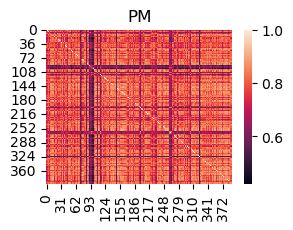

In [43]:
K_dict['K_PM_4_6'] = get_PM(G_adj, 4, 6)

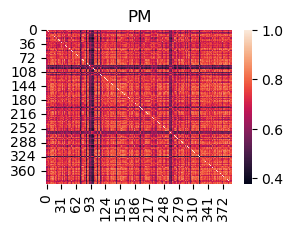

In [44]:
K_dict['K_PM_5_6'] = get_PM(G_adj, 5, 6)

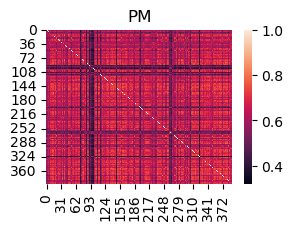

In [45]:
K_dict['K_PM_6_6'] = get_PM(G_adj, 6, 6)

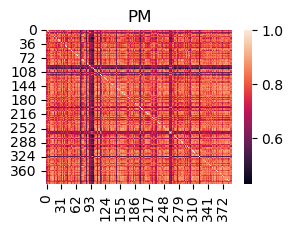

In [46]:
K_dict['K_PM_4_7'] = get_PM(G_adj, 4, 7)

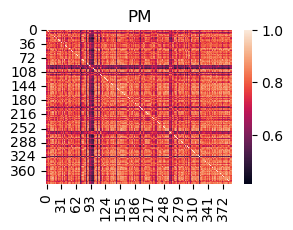

In [47]:
K_dict['K_PM_4_8'] = get_PM(G_adj, 4, 8)

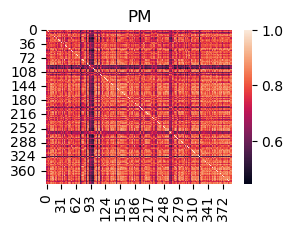

In [48]:
K_dict['K_PM_4_9'] = get_PM(G_adj, 4, 9)

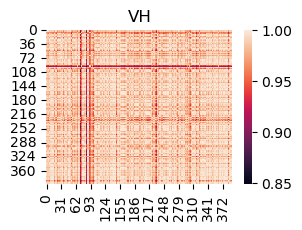

In [49]:
K_dict['K_VH'] = get_VH(G_adj)

In [28]:
def get_NH(G, R_value = 3, bits_value = 8):
    wl_kernel = NeighborhoodHash(normalize=True, R = R_value, bits = bits_value)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'NH-{R_value}-{bits_value}')
    plt.show()
    return K

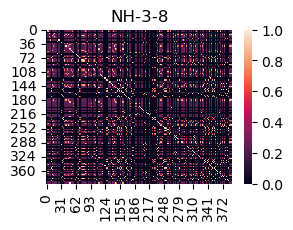

In [52]:
K_dict['K_NH_3_8'] = get_NH(G_adj, 3, 8)

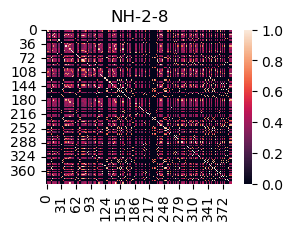

In [53]:
K_dict['K_NH_2_8'] = get_NH(G_adj, 2, 8)

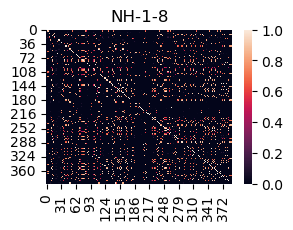

In [54]:
K_dict['K_NH_1_8'] = get_NH(G_adj, 1, 8)

In [36]:
# K_dict['K_NH_1_4'] = get_NH(G_adj, 1, 4)

In [37]:
# K_dict['K_NH_1_6'] = get_NH(G_adj, 1, 6)

## WL [WeisfeilerLehman]

In [55]:
def get_WL(G, iter_num = 1):
    wl_kernel = WeisfeilerLehman(n_iter=iter_num, normalize=True, base_graph_kernel=VertexHistogram)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'WL-{iter_num}')
    plt.show()
    return K

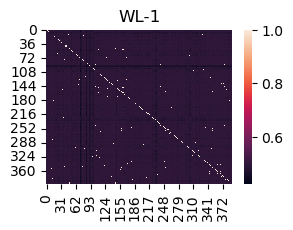

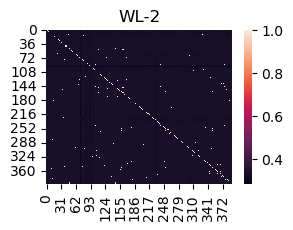

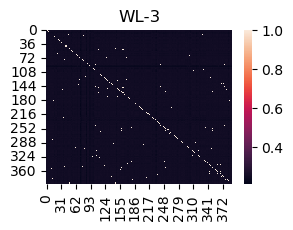

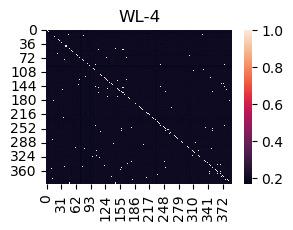

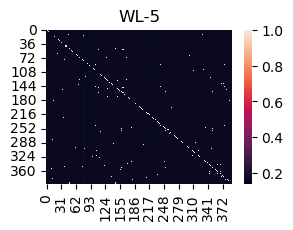

In [56]:
for h in range(1, 6):
    name = f'K_WL_{h}'
    K_dict[name] = get_WL(G_adj, h)

## GS [GraphletSampling]

In [20]:
def get_GS(G, k_num = 4):
    wl_kernel = GraphletSampling(normalize=True, k=k_num)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'GS-{k_num} train')
    plt.show()

    return K

In [21]:
# for k in range(4, 10):
#     name = f'K_GS_{k}'
#     K_dict[name] = get_GS(G_adj, k)

## SP [ShortestPath]

In [50]:
def get_SP(G, algo):
    wl_kernel = ShortestPath(normalize=True, algorithm_type=algo)
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'SP {algo}')
    plt.show()
    
    return K

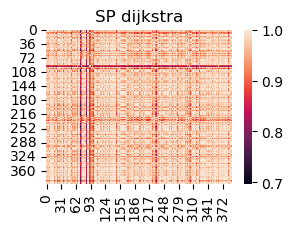

In [51]:
name = 'K_SP'
K_dict[name] = get_SP(G_adj, "dijkstra")

## RW [RandomWalk]

In [60]:
def get_RW(G, lambda_value = 0.1):
    wl_kernel = RandomWalk(lamda=lambda_value, normalize=True, kernel_type="exponential")
    K = wl_kernel.fit_transform(G)

    plt.figure(figsize=(3, 2))
    sns.heatmap(K)
    plt.title(f'RW-{lambda_value}')
    plt.show()

    return K

In [64]:
# for lam in range(5, 6, 5):
#     lam /= 10.
#     name = f'K_RW_{lam}'
#     K_dict[name] = get_RW(G_adj, lam)

In [65]:
import scipy
from scipy.sparse import csgraph
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import pandas as pd

In [66]:
def cal_acc(y_true, y_pred):
    """
    Calculate clustering accuracy.
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind_row, ind_col = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(ind_row, ind_col)]) * 1.0 / y_pred.size


def cal_Lap_eigen(K, class_num):
    L = csgraph.laplacian(K, normed=True)
    eigenValues, eigenVectors = scipy.linalg.eigh(L, subset_by_index=[class_num-1, class_num])
    return (eigenValues, eigenVectors[0], eigenVectors[1])

def gk_L(K, coef = 1):

    n = K.shape[0]
    D = np.sum(K, axis = 0)

    D15 = np.diag(np.power(D, -1.5))
    D05 = np.diag(np.power(D, -0.5))
    D1 = np.diag(np.power(D, -1))

    U0 = - 0.5 * D15 @ K @ D05 * coef
    U1 = - 0.5 * D05 @ K @ D15 * coef

    U0 = np.tile(U0.sum(axis = 1), (n, 1))
    U1 = np.transpose(np.tile(U1.sum(axis = 0), (n, 1)))
    grad_K = - (U0 + U1 + D1 * coef)
    
    return grad_K

def gw_K(K_list):
    return np.array(K_list)

def get_Knew(prev_w, K_list):
    T = len(prev_w)
    p, q = K_list[0].shape

    K_new = np.zeros((p, q))
    for t in range(T):
        K_new += prev_w[t] * K_list[t]
    return K_new

def cal_grad_w(prev_w, K_list, K_new, class_num):

    T = len(prev_w)
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_new, class_num)
    eigen_k = eigenValues[0]
    eigen_gap = np.diff(eigenValues)
    eigen_gap_ratio = eigen_gap/eigen_k
    eigenV_kp1_trace = np.transpose(eigenV_kp1 @ eigenV_kp1)
    eigenV_trace = np.transpose(eigenV @ eigenV)
    inv_trace1 = np.power(eigen_gap, -1) * (eigenV_kp1_trace - eigenV_trace)
    inv_trace2 = np.power(eigen_k,-1) * (eigenV_trace)

    grad_LK = gk_L(K_new, (inv_trace1 - inv_trace2))
    grad_Lw = gw_K(K_list)
    grad = np.sum(np.sum(grad_Lw * grad_LK, axis = 1), axis = 1)

    return grad.flatten(), eigen_gap_ratio


In [67]:
def project_simplex(x):
    """ Take a vector x (with possible nonnegative entries and non-normalized)
        and project it onto the unit simplex.
    """
    xsorted = np.sort(x)[::-1]
    # remaining entries need to sum up to 1
    sum_ = 1.0

    lambda_a = (np.cumsum(xsorted) - sum_) / np.arange(1.0, len(xsorted)+1.0)
    for i in range(len(lambda_a)-1):
        if lambda_a[i] >= xsorted[i+1]:
            astar = i
            break
    else:
        astar = -1

    p = np.maximum(x-lambda_a[astar],  0)
    return p

In [68]:
len(K_dict.values())

16

In [69]:
def train(K_list, init_type, class_num = 2, stepsize = 1e-4, num_iter = 200):
    n = len(K_list)

    score_dict = {'Accuracy': [], "Normalized_Mutual_Info": []}
    weights_list = []
    gap_list = []

    # initialize weights
    if init_type == 'uniform':
        weights = np.ones(n)/n
        
    elif init_type == 'eigen':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            eigen_weights_list.append(eigen_gap)
        eigen_weights = np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'eigen_inv':
        eigen_weights_list = []
        for K_train in K_list:
            eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, class_num)
            eigen_gap = np.diff(eigenValues)
            eigen_weights_list.append(eigen_gap)
        eigen_weights = np.sum(np.array(eigen_weights_list)) - np.array(eigen_weights_list)
        eigen_weights /= np.sum(eigen_weights)
        weights = eigen_weights.ravel()

    elif init_type == 'random':
        weights = np.random.dirichlet(np.ones(n))

    else:
        weights = init_type


    # num_iter_mom = 50
    # update_w = np.zeros(n)
    for i in range(num_iter):
        # if i < num_iter_mom:
        #     momentum = 0.8
        # else:
        #     momentum = 0.2
        K_new = np.nan_to_num(get_Knew(weights, K_list))
        grad, obj = cal_grad_w(weights, K_list, K_new, class_num)

        # update_w = (momentum * update_w) + (stepsize * grad)
        # weights += update_w
        weights += (stepsize * grad)
        weights = project_simplex(weights)

        weights_list.append(weights)
        gap_list.append(obj)
        y_pred = SpectralClustering(n_clusters = class_num, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_new)

        acc_score = cal_acc(y_adj, y_pred)
        nmi = metrics.normalized_mutual_info_score(y_adj, y_pred)
        score_dict['Accuracy'].append(acc_score)
        score_dict['Normalized_Mutual_Info'].append(nmi)

        if (i%10 == 0): 
            weight_norm = np.linalg.norm(weights)
            weight_sum = np.sum(weights)
            print(f'----- At No.{i+1} iteration: sum: {np.round(weight_sum, 4)} norm: {np.round(weight_norm, 4)}-----')
            print(f"eigengap ratio: {obj}")
            print(f"acc_score: {acc_score}; nmi: {nmi}\n")


    plt.plot(range(num_iter), gap_list)
    plt.title(f'Eigengap Ratio')
    plt.xlabel = 'Num of Iterations'
    plt.show()

    return K_new, weights, score_dict

In [70]:
def display_results(kernel_name, K_list, weights, score_dict, num_iter, class_num):
    print('===== Individual acc_score | nmi=====')
    i = 0
    for K_candidate in K_list:
        y_pred = SpectralClustering(n_clusters = class_num, 
                                    random_state = 0,
                                    affinity = 'precomputed').fit_predict(K_candidate)

        acc_score = cal_acc(y_adj, y_pred)
        nmi = metrics.normalized_mutual_info_score(y_adj, y_pred)
        print("%s: %.4f(acc); %.4f(nmi) | weight: %.4f"%(kernel_name[i], acc_score, nmi, weights[i]))
        i += 1

    print('===== Joint kernel =====')
    plt.plot(range(num_iter), pd.DataFrame(score_dict))
    plt.title('Acc: %.4f; NMI: %.4f'%(max(score_dict["Accuracy"]), max(score_dict["Normalized_Mutual_Info"])))
    plt.legend(list(score_dict.keys()))
    plt.xlabel = 'Num of Iterations'
    plt.show()

# All kernels

In [71]:
eigen_weights_list = []
K_list = list(K_dict.values())
for K_train in K_list:
    eigenValues, eigenV_kp1, eigenV = cal_Lap_eigen(K_train, len(np.unique(y)))
    eigen_gap = np.diff(eigenValues)
    eigen_weights_list.append(eigen_gap)
print(dict(zip(list(K_dict.keys()), eigen_weights_list)))

{'K_PM_4_6': array([0.0309058]), 'K_PM_5_6': array([0.02526597]), 'K_PM_6_6': array([0.01654534]), 'K_PM_4_7': array([0.02996774]), 'K_PM_4_8': array([0.02970263]), 'K_PM_4_9': array([0.02972034]), 'K_VH': array([0.00276708]), 'K_SP': array([0.00610959]), 'K_NH_3_8': array([0.00011834]), 'K_NH_2_8': array([2.65582106e-16]), 'K_NH_1_8': array([1.62773802e-16]), 'K_WL_1': array([0.0028733]), 'K_WL_2': array([0.00517378]), 'K_WL_3': array([0.00741576]), 'K_WL_4': array([0.00954772]), 'K_WL_5': array([0.01156864])}


## Uniform init

----- At No.1 iteration: sum: 1.0 norm: 0.2641-----
eigengap ratio: [0.00851373]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.11 iteration: sum: 1.0 norm: 0.3659-----
eigengap ratio: [0.08897077]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.21 iteration: sum: 1.0 norm: 0.3933-----
eigengap ratio: [0.12278198]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.31 iteration: sum: 1.0 norm: 0.4097-----
eigengap ratio: [0.14272259]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.41 iteration: sum: 1.0 norm: 0.433-----
eigengap ratio: [0.16912698]
acc_score: 0.8829516539440203; nmi: 0.0022696539036088

----- At No.51 iteration: sum: 1.0 norm: 0.4485-----
eigengap ratio: [0.18865801]
acc_score: 0.8829516539440203; nmi: 0.0022696539036088

----- At No.61 iteration: sum: 1.0 norm: 0.4699-----
eigengap ratio: [0.21294588]
acc_score: 0.8829516539440203; nmi: 0.0022696539036088

----- At No.71 itera

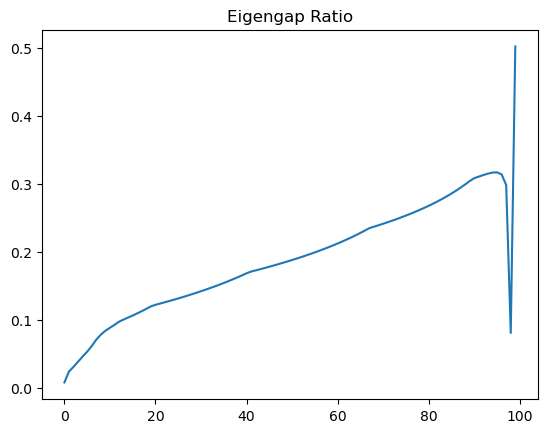

Final weights: [0.05472631 0.         0.         0.05626614 0.05464901 0.05427638
 0.40661049 0.37347166 0.         0.         0.         0.
 0.         0.         0.         0.        ]
===== Individual acc_score | nmi=====
K_PM_4_6: 0.7201(acc); 0.0225(nmi) | weight: 0.0547
K_PM_5_6: 0.7201(acc); 0.0133(nmi) | weight: 0.0000
K_PM_6_6: 0.7430(acc); 0.0178(nmi) | weight: 0.0000
K_PM_4_7: 0.7048(acc); 0.0212(nmi) | weight: 0.0563
K_PM_4_8: 0.7099(acc); 0.0194(nmi) | weight: 0.0546
K_PM_4_9: 0.6692(acc); 0.0207(nmi) | weight: 0.0543
K_VH: 0.5165(acc); 0.0008(nmi) | weight: 0.4066
K_SP: 0.5471(acc); 0.0015(nmi) | weight: 0.3735
K_NH_3_8: 0.9898(acc); 0.0117(nmi) | weight: 0.0000
K_NH_2_8: 0.9313(acc); 0.0028(nmi) | weight: 0.0000
K_NH_1_8: 0.8270(acc); 0.0015(nmi) | weight: 0.0000
K_WL_1: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_2: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_3: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_4: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_5: 0.9

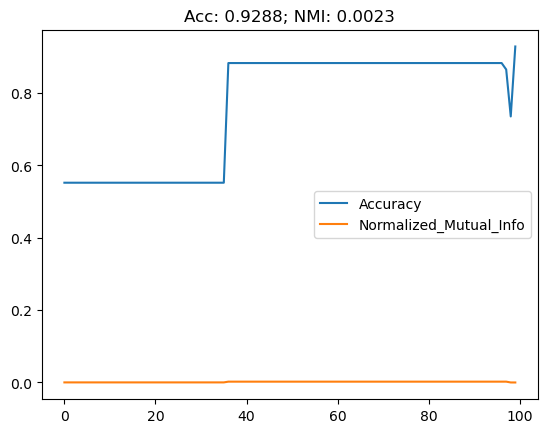

In [74]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'uniform', class_num, 5e-5, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

K's min eigenvalue: (-2.239268358232201e-16+0j)


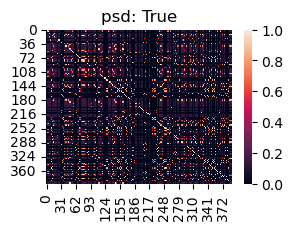

In [75]:
# for K_train in K_list:
#     check_psd(K_train)
check_psd(K_new)

## Eigen init

----- At No.1 iteration: sum: 1.0 norm: 0.3351-----
eigengap ratio: [0.0272227]
acc_score: 0.7175572519083969; nmi: 0.02000438216833984

----- At No.11 iteration: sum: 1.0 norm: 0.3197-----
eigengap ratio: [0.02750118]
acc_score: 0.7175572519083969; nmi: 0.02000438216833984

----- At No.21 iteration: sum: 1.0 norm: 0.3036-----
eigengap ratio: [0.02534854]
acc_score: 0.7175572519083969; nmi: 0.02000438216833984

----- At No.31 iteration: sum: 1.0 norm: 0.3153-----
eigengap ratio: [0.03362958]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.41 iteration: sum: 1.0 norm: 0.392-----
eigengap ratio: [0.10505783]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.51 iteration: sum: 1.0 norm: 0.4061-----
eigengap ratio: [0.12266644]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.61 iteration: sum: 1.0 norm: 0.4246-----
eigengap ratio: [0.14429632]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.71 ite

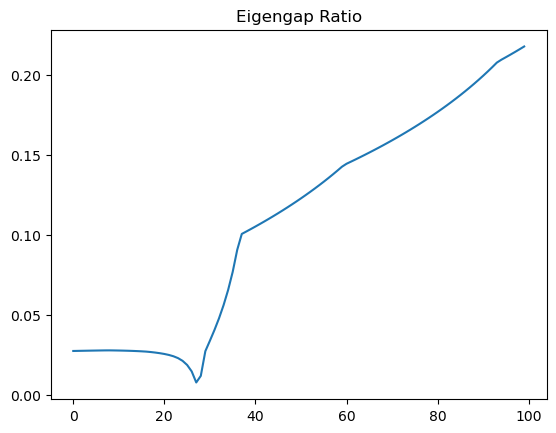

Final weights: [0.         0.         0.         0.         0.         0.
 0.         0.         0.22857287 0.17439172 0.34590499 0.
 0.         0.         0.08626549 0.16486494]
===== Individual acc_score | nmi=====
K_PM_4_6: 0.7201(acc); 0.0225(nmi) | weight: 0.0000
K_PM_5_6: 0.7201(acc); 0.0133(nmi) | weight: 0.0000
K_PM_6_6: 0.7430(acc); 0.0178(nmi) | weight: 0.0000
K_PM_4_7: 0.7048(acc); 0.0212(nmi) | weight: 0.0000
K_PM_4_8: 0.7099(acc); 0.0194(nmi) | weight: 0.0000
K_PM_4_9: 0.6692(acc); 0.0207(nmi) | weight: 0.0000
K_VH: 0.5165(acc); 0.0008(nmi) | weight: 0.0000
K_SP: 0.5471(acc); 0.0015(nmi) | weight: 0.0000
K_NH_3_8: 0.9898(acc); 0.0117(nmi) | weight: 0.2286
K_NH_2_8: 0.9313(acc); 0.0028(nmi) | weight: 0.1744
K_NH_1_8: 0.8270(acc); 0.0015(nmi) | weight: 0.3459
K_WL_1: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_2: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_3: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_4: 0.9822(acc); 0.0042(nmi) | weight: 0.0863
K_WL_5: 0.9822(acc)

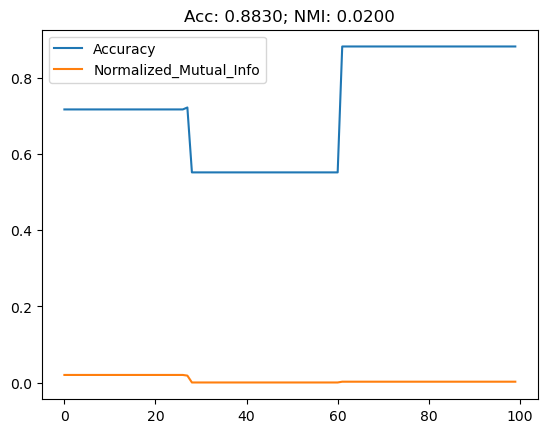

In [78]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'eigen', class_num, 5e-5, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

----- At No.1 iteration: sum: 1.0 norm: 0.2632-----
eigengap ratio: [0.0123922]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.11 iteration: sum: 1.0 norm: 0.3646-----
eigengap ratio: [0.08835626]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.21 iteration: sum: 1.0 norm: 0.393-----
eigengap ratio: [0.12319536]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.31 iteration: sum: 1.0 norm: 0.4094-----
eigengap ratio: [0.14310278]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.41 iteration: sum: 1.0 norm: 0.4331-----
eigengap ratio: [0.16945422]
acc_score: 0.8829516539440203; nmi: 0.0022696539036088

----- At No.51 iteration: sum: 1.0 norm: 0.4489-----
eigengap ratio: [0.18988836]
acc_score: 0.8829516539440203; nmi: 0.0022696539036088

----- At No.61 iteration: sum: 1.0 norm: 0.4704-----
eigengap ratio: [0.21445419]
acc_score: 0.8829516539440203; nmi: 0.0022696539036088

----- At No.71 iterat

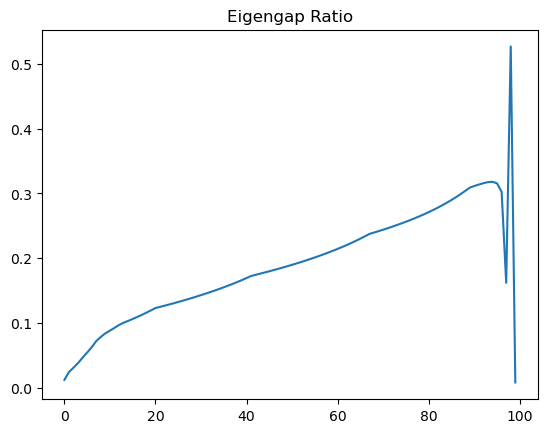

Final weights: [0.06169614 0.         0.         0.0631143  0.06163259 0.06129861
 0.38459284 0.35415288 0.00231657 0.00213167 0.00271907 0.
 0.00098924 0.00150845 0.00181998 0.00202766]
===== Individual acc_score | nmi=====
K_PM_4_6: 0.7201(acc); 0.0225(nmi) | weight: 0.0617
K_PM_5_6: 0.7201(acc); 0.0133(nmi) | weight: 0.0000
K_PM_6_6: 0.7430(acc); 0.0178(nmi) | weight: 0.0000
K_PM_4_7: 0.7048(acc); 0.0212(nmi) | weight: 0.0631
K_PM_4_8: 0.7099(acc); 0.0194(nmi) | weight: 0.0616
K_PM_4_9: 0.6692(acc); 0.0207(nmi) | weight: 0.0613
K_VH: 0.5165(acc); 0.0008(nmi) | weight: 0.3846
K_SP: 0.5471(acc); 0.0015(nmi) | weight: 0.3542
K_NH_3_8: 0.9898(acc); 0.0117(nmi) | weight: 0.0023
K_NH_2_8: 0.9313(acc); 0.0028(nmi) | weight: 0.0021
K_NH_1_8: 0.8270(acc); 0.0015(nmi) | weight: 0.0027
K_WL_1: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_2: 0.9822(acc); 0.0042(nmi) | weight: 0.0010
K_WL_3: 0.9822(acc); 0.0042(nmi) | weight: 0.0015
K_WL_4: 0.9822(acc); 0.0042(nmi) | weight: 0.0018
K_WL_5: 0.9

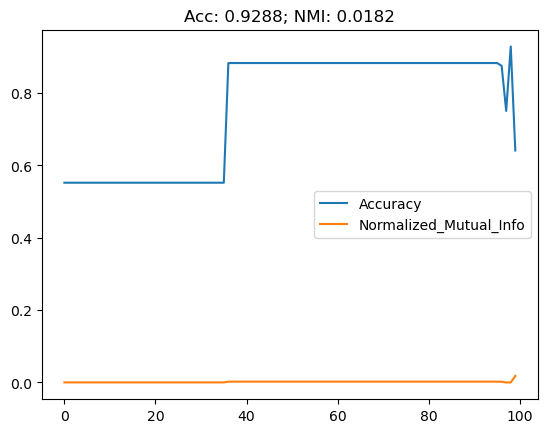

In [79]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'eigen_inv', class_num, 5e-5, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)

## Random init

----- At No.1 iteration: sum: 1.0 norm: 0.3309-----
eigengap ratio: [0.017317]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.11 iteration: sum: 1.0 norm: 0.4009-----
eigengap ratio: [0.09780631]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.21 iteration: sum: 1.0 norm: 0.4231-----
eigengap ratio: [0.13095933]
acc_score: 0.5521628498727735; nmi: 0.00022585091082075965

----- At No.31 iteration: sum: 1.0 norm: 0.4589-----
eigengap ratio: [0.1752421]
acc_score: 0.8829516539440203; nmi: 0.0022696539036088

----- At No.41 iteration: sum: 1.0 norm: 0.4894-----
eigengap ratio: [0.21456078]
acc_score: 0.8829516539440203; nmi: 0.0022696539036088

----- At No.51 iteration: sum: 1.0 norm: 0.5249-----
eigengap ratio: [0.25558021]
acc_score: 0.8829516539440203; nmi: 0.0022696539036088

----- At No.61 iteration: sum: 1.0 norm: 0.7087-----
eigengap ratio: [0.49945359]
acc_score: 0.9287531806615776; nmi: 2.6633687900954765e-07

----- At No.71 iterati

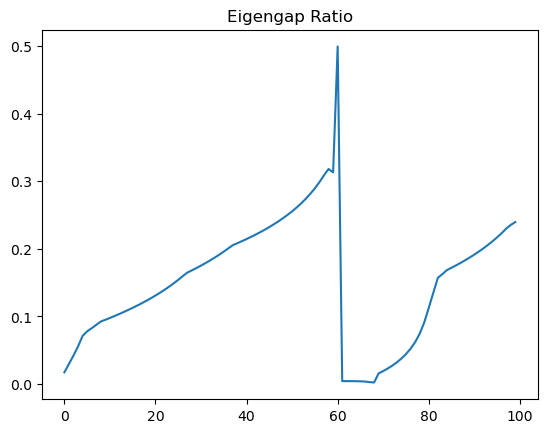

Final weights: [0.         0.         0.         0.         0.         0.
 0.         0.         0.24451591 0.19515227 0.35303703 0.
 0.         0.         0.0719536  0.13534119]
===== Individual acc_score | nmi=====
K_PM_4_6: 0.7201(acc); 0.0225(nmi) | weight: 0.0000
K_PM_5_6: 0.7201(acc); 0.0133(nmi) | weight: 0.0000
K_PM_6_6: 0.7430(acc); 0.0178(nmi) | weight: 0.0000
K_PM_4_7: 0.7048(acc); 0.0212(nmi) | weight: 0.0000
K_PM_4_8: 0.7099(acc); 0.0194(nmi) | weight: 0.0000
K_PM_4_9: 0.6692(acc); 0.0207(nmi) | weight: 0.0000
K_VH: 0.5165(acc); 0.0008(nmi) | weight: 0.0000
K_SP: 0.5471(acc); 0.0015(nmi) | weight: 0.0000
K_NH_3_8: 0.9898(acc); 0.0117(nmi) | weight: 0.2445
K_NH_2_8: 0.9313(acc); 0.0028(nmi) | weight: 0.1952
K_NH_1_8: 0.8270(acc); 0.0015(nmi) | weight: 0.3530
K_WL_1: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_2: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_3: 0.9822(acc); 0.0042(nmi) | weight: 0.0000
K_WL_4: 0.9822(acc); 0.0042(nmi) | weight: 0.0720
K_WL_5: 0.9822(acc)

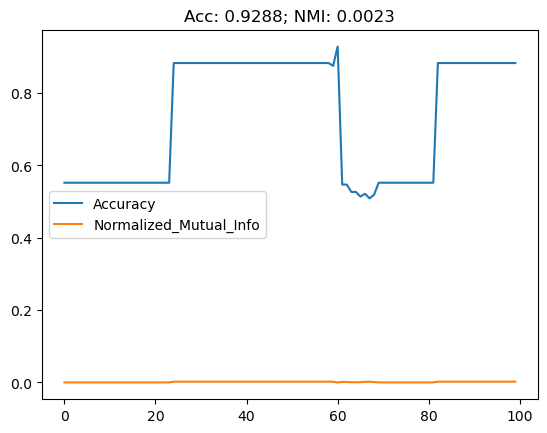

In [80]:
K_list = list(K_dict.values())
num_iter = 100
class_num = len(np.unique(y))
K_new, weights, score_dict = train(K_list, 'random', class_num, 1e-4, num_iter)
print("Final weights:", weights)
display_results(list(K_dict.keys()), K_list, weights, score_dict, num_iter, class_num)